# Integration

### Zhentao Shi

<img src="graph/damaoshan.jpeg" width="1000">

<!-- code is tested on SCRP -->

* Stochastic integration
* Markov Chain Monte Carlo (MCMC)


## Numerical Methods

* Numerical differentiation and integration

* Use case: To find the optimum for the objective function $f:R^K \mapsto R$
by Newton's method, 
  * $K$-dimensional gradient   
  * $K\times K$-dimensional Hessian matrix.

* Programming up the gradient and the Hessian manually is a time-consuming and error-prone job
* Whenever we change the objective function, we have to redo the gradient and Hessian

* More efficient to use numerical differentiation instead of the analytical expressions

The partial derivative of a multivariate function
$f:R^K \mapsto R$ at a point $x_0 \in R^K$ is

$$
\frac{\partial f(x)}{\partial x_k}\bigg|_{x=x_0}=\lim_{\epsilon \to 0}
\frac{f(x_0+\epsilon \cdot e_k) - f(x_0 - \epsilon \cdot e_k)}{2\epsilon},
$$

where $e_k = (0,\ldots,0,1,0,\ldots,0)$ is the identifier of the $k$-th coordinate.

* Numerical execution in a computer follows the basic definition to evaluate
$f(x_0\pm\epsilon \cdot e_k))$ with a small
$\epsilon$. 

* How small is small? Usually we try a sequence of $\epsilon$'s until
the numerical derivative is stable. 

* There are also more sophisticated algorithms.

## Caution

* Numerical methods are not panacea
* Not all functions are differentiable or integrable.
* Before turning to numerical methods, it is always imperative to try to understand the behavior of the function at the first place.
* AI tools can be very helpful in these math calculation and coding.

## Stochastic Integration

* An alternative to analytic/numerical integration is the stochastic methods.
* The underlying principle of stochastic integration is the law of large numbers.

* Let  $\int h(x) d F(x)$ be an integral where $F(x)$ is a probability distribution.
* Approximate the integral by
$\int h(x) d F(x) \approx S^{-1} \sum_{s=1}^S h(x_s)$, where $x_s$ is randomly
generated from $F(x)$.

* When $S$ is large, a law of large numbers gives

$$
S^{-1} \sum_{s=1}^S h(x_s) \stackrel{\mathrm{p}}{\to} E[h(x)] = \int h(x) d F(x).
$$

* If the integration is carried out not in the entire support of $F(x)$ but on a subset $A$, then

$$
\int_A h(x) d F(x) \approx S^{-1} \sum_{s=1}^S h(x_s) \cdot 1\{x_s \in A\},
$$

where $1\{\cdot\}$ is the indicator function.

* In theory, use an $S$ as large as possible.
* In reality, constrained by the computer's memory and computing time.
* No clear guidance of the size of $S$ in practice. 
* Preliminary experiment can help decide an $S$ that produces stable results.

* Stochastic integration is popular in econometrics and statistics, thanks to its convenience in execution.

**Example**: Use simulated maximum likelihood to estimate the parameters of a binary choice model.

In [1]:
import numpy as np

beta_true = [0.5, 0.5]  # True coefficients
n = 1000           # Number of observations
k = len(beta_true)      # Number of coefficients

# Generate data
X = np.random.rand(n, k) 
X[:, 0] = 1  # Intercept

error = np.random.normal(0, 1, size=n)
y_latent = np.dot(X, beta_true) + error

y = (y_latent > 0).astype(int)

In [2]:
import nlopt

# Define the simulated likelihood function
def sim_likelihood(params, n_sims=500):
    """
    Simulated likelihood function for the Probit model.
    """
    beta = params
    # Simulate the latent variable
    error_sim = np.random.normal(0, 1, size=(n, n_sims))
    y_latent_sim = np.tile( (X @ beta).reshape(-1, 1), n_sims) + error_sim
    # Calculate the probability of observed y
    prob = np.mean(y_latent_sim > 0, axis=1)
    # Likelihood contribution
    ll = np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))
    return -ll  # Minimize the negative log-likelihood

In [3]:
# Estimate the parameters using SML
# Initial guess for parameters
beta_guess = [0.2, 0.2]

# Define the objective function for nlopt
def objective_function(params, grad):
    return sim_likelihood(params)

# Set up the optimizer
opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(beta_guess))
opt.set_min_objective(objective_function)
opt.set_xtol_rel(1e-6)

# Run the optimization
beta_opt = opt.optimize(beta_guess)
minf = opt.last_optimum_value()

# Print the results
print("True parameters:", beta_true)
print("Estimated parameters:", beta_opt)
print("Value of the criterion function:", minf)

True parameters: [0.5, 0.5]
Estimated parameters: [0.50117188 0.41640625]
Value of the criterion function: 539.6919760976151


### Random Variable Generation

* **If the CDF $F(X)$ is known**, we can generate random variables that follow such a distribution.
  * Draw $U$ from  $\mathrm{Uniform}(0,1)$
  * Compute $X = F^{-1}(U)$

## Markov Chain Monte Carlo

* **If the pdf $f(X)$ is known**, we can generate a sample by *importance sampling*
  * [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)
 (MH algorithm) is such a method.
  * MH is one of the [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods.

### Metropolis-Hastings Algorithm

* Theory of the MH requires long derivation
* Implementation is straightforward.

### Example

Use MH to generate a sample of normally distributed observations with
$\mu = 1$ and $\sigma = 0.5$.

* In the function `metrop`, we provide the logarithm of the density of

$$
\log f(x) = -\frac{1}{2} \log (2\pi) - \log \sigma - \frac{1}{2\sigma^2} (x-\mu)^2
$$

  * The first term can be omitted as it is irrelevant to the parameter.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

# the target distribution
def h(x, mu=1, sd=0.5):
    return -np.log(sd) - (x - mu)**2 / (2 * sd**2)

In [5]:
# a self-defined metropolis algorithm

def metropolis(h, initial, n_samples, n_spac, proposal_sd=0.5):
# h: log density function. It's a function. 
# initial: initial value
# n_samples: total number of samples to generate
# n_spac: number of samples to generate before saving one
# proposal_sd: standard deviation of the normal proposal distribution
    
    total_iter = n_samples * n_spac
    chain = []
    current = initial
    current_h = h(current)
    for i in range(total_iter):
        proposal = current + np.random.normal(0, proposal_sd) # normal proposal distribution
        # the proposal distribution is symmetric. It determines the acceptance probability
        proposal_h = h(proposal)
        if np.log(np.random.rand()) < (proposal_h - current_h):
            current = proposal
            current_h = proposal_h
        if (i + 1) % n_spac == 0:
            chain.append(current)
    return np.array(chain)

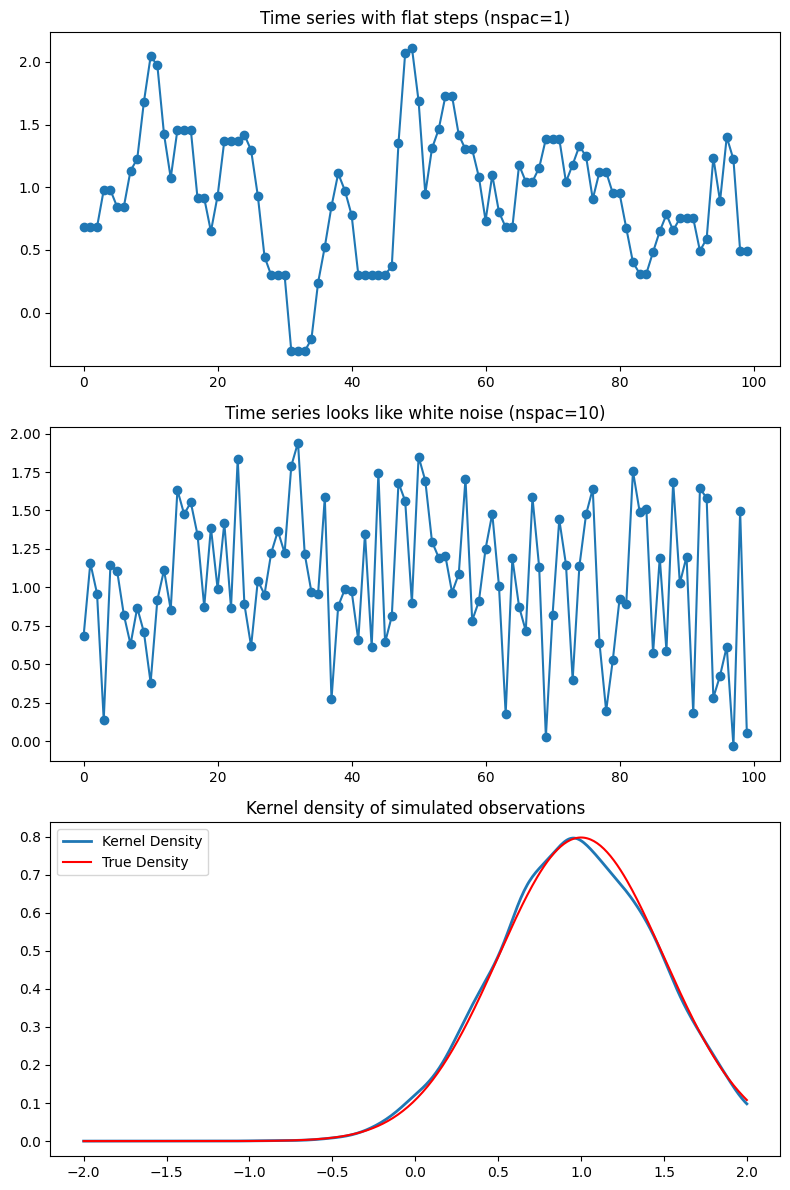

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# 1) Time series with flat steps: nbatch=100, nspac=1
chain1 = metropolis(h, initial=0, n_samples=100, n_spac=1)
axes[0].plot(chain1, linestyle='-', marker='o')
axes[0].set_title("Time series with flat steps (nspac=1)")

# 2) Time series with reduced serial correlation: nbatch=100, nspac=10
chain2 = metropolis(h, initial=0, n_samples=100, n_spac=10)
axes[1].plot(chain2, linestyle='-', marker='o')
axes[1].set_title("Time series looks like white noise (nspac=10)")

# 3) Density estimate versus true density: nbatch=10000, nspac=10
chain3 = metropolis(h, initial=0, n_samples=10000, n_spac=10)
density = gaussian_kde(chain3)
xbase = np.linspace(-2, 2, 400)
axes[2].plot(xbase, density(xbase), lw=2, label="Kernel Density")
axes[2].plot(xbase, norm.pdf(xbase, loc=1, scale=0.5), color='red', label="True Density")
axes[2].set_title("Kernel density of simulated observations")
axes[2].legend()

plt.tight_layout()
plt.show()

### Outcomes

* The first panel is a time series where
the marginal distribution of each observations follows $N(1,0.5^2)$. 
  * Time dependence is visible
  * flat regions are observed when the Markov chain rejects a new proposal
so the value does not update over two periods. 

* The middle panel collects the time series every 10 observations on the Markov chain
  * serial correlation is weakened
  * No flat region is observed
 
  
* The third panel compares     
  * kernel density of the simulated observations (black curve) 
  * density function of $N(1,0.5^2)$ (red curve).


### Bayesian Inference


* Bayesian framework offers a coherent and natural language for statistical decision. 
* Bayesian views both the data $\mathbf{X}_{n}$ and the
parameter $\theta$ as random variables
* Before observeing the data, researcher holds a *prior distribution* $\pi$ about $\theta$
* After observing the data, researcher updates the prior distribution to a *posterior distribution* $p(\theta|\mathbf{X}_{n})$. 


### Bayes Theorem

* Let $f(\mathbf{X}_{n}|\theta)$ be the likelihood
* Let $\pi$ be the prior

* The celebrated Bayes Theorem is

$$
p(\theta|\mathbf{X}_{n})\propto f(\mathbf{X}_{n}|\theta)\pi(\theta)
$$




### Classical Analytical Example 

* $\mathbf{X}_{n}=(X_{1},\ldots,X_{n})$ is an iid sample drawn from a normal distribution with unknown $\theta$ and known $\sigma$
* If a researcher's prior distribution
$\theta\sim N(\theta_{0},\sigma_{0}^{2})$, her posterior distribution
is, by some routine calculation, also a normal distribution

$$
p(\theta|\mathbf{x}_{n})\sim N\left(\tilde{\theta},\tilde{\sigma}^{2}\right),
$$

where
$\tilde{\theta}=\frac{\sigma_{0}^{2}}{n\sigma^{2}+\sigma_{0}^{2}}\theta_{0}+\frac{n\sigma^{2}}{n\sigma^{2}+\sigma_{0}^{2}}\bar{x}$
and
$\tilde{\sigma}^{2}=\frac{\sigma_{0}^{2}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^{2}}$.


### Bayesian Credible Set

$$
\left(\tilde{\theta}-z_{1-\alpha/2}\cdot\tilde{\sigma},\ \tilde{\theta}+z_{1-\alpha/2}\cdot\tilde{\sigma}\right).
$$

* Posterior distribution depends on $\theta_{0}$ and $\sigma_{0}^{2}$
from the prior. 
* When the sample size is sufficiently, the data overwhelms the prior


### Frequentist Confidence Internval


* $\hat{\theta}=\bar{x}\sim N(\theta,\sigma^{2}/n)$. 

* Confidence interval is

$$
\left(\bar{x}-z_{1-\alpha/2}\cdot\sigma/\sqrt{n},\ \bar{x}-z_{1-\alpha/2}\cdot\sigma/\sqrt{n}\right).
$$

### Comparison

* Bayesian produces a posterior distribution
  * The posterior distribution implies point estimates and credible set
  * Data are fixed (invariant)
  * A prior distribution is needed

* Frequestist produces a point estimator
  * Before data are observed, the point estimator is random
  * Inference is imply by the point estimator **before observation**
  * Only data are realized, the point estimate is a fixed number
  * No prior distribution is needed
  

* The nature generates data
* The researcher correctly specifies the normal model
* Given the data, she infers $\theta$ according to the posterior distribution

### Code Example

* Conduct inference about the mean parameter of a normal with unit variance
* Prior distribution $\mu \sim Beta(2,2)$
* [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is flexible

In [7]:
from scipy.stats import beta

n = 2000

# generate n random numbers from a normal distribution
x = np.random.normal(size=n) + 0.9

def loglik(theta):
    # Computes the sum of log densities of x ~ N(theta, 1)
    return np.sum(norm.logpdf(x, loc=theta, scale=1))

def posterior(theta):
    # Adds the log density of a Beta(2,2) prior to the log-likelihood
    return loglik(theta) + beta.logpdf(theta, a=2, b=2)


In [8]:
nbatch = 10000
out = metropolis(posterior, initial=0.1, n_samples=nbatch, n_spac=10)
burn_in = round(nbatch / 10)
out = out[burn_in:]  # remove the burn-in period

# Plot the kernel density of the posterior draws
density_est = gaussian_kde(out)
x_grid = np.linspace(out.min(), out.max(), 200)

# Print the 95% quantile interval
quat = np.quantile(out, [0.025, 0.975])


[0.88195448 0.96347909]


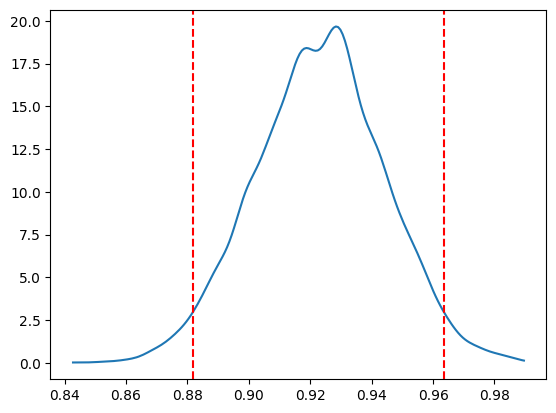

In [9]:
print(quat)

# plot the two values in quat as vertical lines
plt.figure()
plt.plot(x_grid, density_est(x_grid))

plt.axvline(quat[0], color='red', linestyle='--')
plt.axvline(quat[1], color='red', linestyle='--')
plt.show()


### Finance Application with Real Data: Bayesian Credit-Risk Level

* **Industry context**: A bank tracks U.S. credit-card delinquency risk for stress testing and provisioning.
* **Real data source**: FRED series `DRCCLACBS` (Delinquency Rate on Credit Card Loans, All Commercial Banks, Percent).
* We estimate the underlying delinquency level $\theta$ (in percentage points) for the recent regime.

Model:

$$
y_t \mid \theta \sim N(\theta, \sigma^2), \quad t=1,\ldots,n
$$

with prior

$$
\theta \sim N(\theta_0, \tau_0^2).
$$

Posterior (normal-normal conjugacy):

$$
\theta \mid \mathbf{y} \sim N(\tilde{\theta}, \tilde{\tau}^2),
$$

where

$$
\tilde{\tau}^2 = \left(\frac{n}{\sigma^2}+\frac{1}{\tau_0^2}\right)^{-1},
\quad
\tilde{\theta} = \tilde{\tau}^2\left(\frac{n\bar{y}}{\sigma^2}+\frac{\theta_0}{\tau_0^2}\right).
$$


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader.data as web

# Real data from FRED
series_id = 'DRCCLACBS'  # Delinquency Rate on Credit Card Loans, %
raw = web.DataReader(series_id, 'fred', '2000-01-01', '2025-12-31').dropna()

# Focus on recent regime for risk monitoring
y = raw.loc['2016-01-01':, series_id].astype(float)

# Likelihood with plug-in sigma (sample std of observed rates)
n = len(y)
ybar = y.mean()
sigma = y.std(ddof=1)
sigma2 = sigma**2

# Prior belief from historical risk management experience
theta0 = 3.0   # prior mean delinquency rate in %
tau0 = 1.0     # prior std in percentage points
tau02 = tau0**2

# Posterior update
tau_post2 = 1.0 / (n / sigma2 + 1.0 / tau02)
theta_post = tau_post2 * (n * ybar / sigma2 + theta0 / tau02)
tau_post = np.sqrt(tau_post2)

ci = norm.ppf([0.025, 0.975], loc=theta_post, scale=tau_post)

print(f"FRED series: {series_id}")
print(f"Sample window: {y.index.min().date()} to {y.index.max().date()} ({n} quarters)")
print(f"Sample mean delinquency rate: {ybar:.3f}%")
print(f"Posterior mean delinquency rate: {theta_post:.3f}%")
print(f"95% Bayesian credible interval: [{ci[0]:.3f}%, {ci[1]:.3f}%]")


FRED series: DRCCLACBS
Sample window: 2016-01-01 to 2025-07-01 (39 quarters)
Sample mean delinquency rate: 2.461%
Posterior mean delinquency rate: 2.464%
95% Bayesian credible interval: [2.317%, 2.610%]


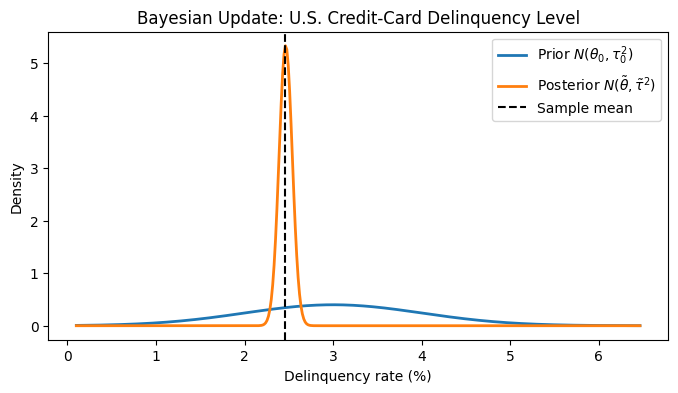

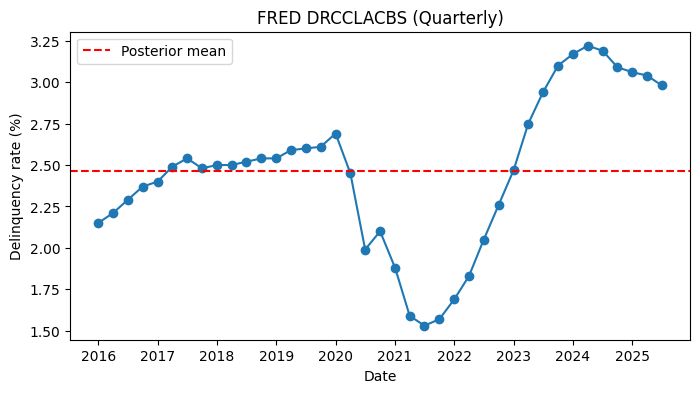

In [11]:
# Prior vs posterior density for delinquency level (percentage points)
grid = np.linspace(max(0.1, theta_post - 4 * tau0), theta_post + 4 * tau0, 400)
prior_pdf = norm.pdf(grid, loc=theta0, scale=tau0)
post_pdf = norm.pdf(grid, loc=theta_post, scale=tau_post)

plt.figure(figsize=(8, 4))
plt.plot(grid, prior_pdf, label=r'Prior $N(\theta_0, \tau_0^2)$', linewidth=2)
plt.plot(grid, post_pdf, label=r'Posterior $N(\tilde{\theta}, \tilde{\tau}^2)$', linewidth=2)
plt.axvline(ybar, color='black', linestyle='--', label='Sample mean')
plt.title('Bayesian Update: U.S. Credit-Card Delinquency Level')
plt.xlabel('Delinquency rate (%)')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(y.index, y.values, marker='o', linewidth=1.5)
plt.axhline(theta_post, color='red', linestyle='--', label='Posterior mean')
plt.title('FRED DRCCLACBS (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Delinquency rate (%)')
plt.legend()
plt.show()


### Posterior Expected Loss Distribution

Suppose a credit-card portfolio has exposure-at-default (EAD) of $50 million and loss-given-default (LGD) of 60%.

Using delinquency rate as a portfolio risk proxy,

$$
\text{Expected Loss} = \text{EAD} \times \text{LGD} \times \frac{\theta}{100}.
$$

Since $\theta$ has a posterior distribution, expected loss also has a posterior distribution.


Posterior mean expected loss: $739,337
90% posterior interval: [$702,654, $775,974]


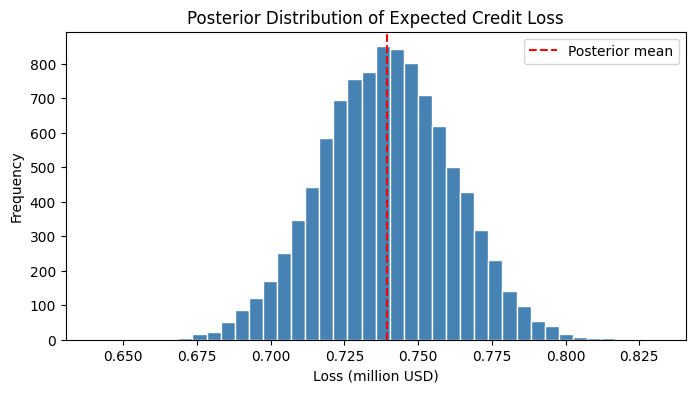

In [12]:
ead = 50_000_000
lgd = 0.60

# Posterior simulation
np.random.seed(5821)
theta_draws = np.random.normal(theta_post, tau_post, size=10000)
theta_draws = np.clip(theta_draws, 0.0, None)  # keep rates nonnegative
loss_draws = ead * lgd * (theta_draws / 100.0)

loss_mean = loss_draws.mean()
loss_q05, loss_q95 = np.quantile(loss_draws, [0.05, 0.95])

print(f"Posterior mean expected loss: ${loss_mean:,.0f}")
print(f"90% posterior interval: [${loss_q05:,.0f}, ${loss_q95:,.0f}]")

plt.figure(figsize=(8, 4))
plt.hist(loss_draws / 1e6, bins=40, color='steelblue', edgecolor='white')
plt.axvline(loss_mean / 1e6, color='red', linestyle='--', label='Posterior mean')
plt.title('Posterior Distribution of Expected Credit Loss')
plt.xlabel('Loss (million USD)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


*Interpretation*: This real-data Bayesian workflow turns public macro-financial credit indicators into a full uncertainty distribution for portfolio loss, which is directly usable for provisioning, risk limits, and scenario communication.

### Extension: Non-Normal Prior + MCMC Posterior (Using `emcee`)

Now keep the same real-data likelihood and use a **non-normal prior** for the delinquency level:

$$
\theta \sim \text{Gamma}(a,b), \quad \theta>0.
$$

We directly invoke `emcee` and use a **Gaussian Metropolis-Hastings move** (`emcee.moves.GaussianMove`) to sample from the posterior.


In [13]:
import numpy as np
import emcee
from scipy.stats import gamma, gaussian_kde

# Reuse y and sigma from the real-data section above
# Non-normal prior: Gamma(shape=a_prior, scale=b_prior)
a_prior = 6.0
b_prior = 0.5  # prior mean = a_prior * b_prior = 3.0

# log posterior for emcee (input theta is a 1-d vector)
def logpost_gamma_prior(theta_vec):
    theta = float(theta_vec[0])
    if theta <= 0:
        return -np.inf
    ll = np.sum(norm.logpdf(y.values, loc=theta, scale=sigma))
    lp = gamma.logpdf(theta, a=a_prior, scale=b_prior)
    return ll + lp

np.random.seed(5821)

# emcee setup
ndim = 1
nwalkers = 32
proposal_sd = 0.08

init_center = max(0.5, float(y.mean()))
p0 = init_center + 0.05 * np.random.randn(nwalkers, ndim)
p0 = np.clip(p0, 1e-3, None)

# GaussianMove is a Metropolis-Hastings random-walk proposal
mh_move = emcee.moves.GaussianMove(cov=proposal_sd**2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost_gamma_prior, moves=mh_move)

# burn-in + production
state = sampler.run_mcmc(p0, 3000, progress=False)
sampler.reset()
sampler.run_mcmc(state, 8000, progress=False)

draws = sampler.get_chain(flat=True)[:, 0]
accept_rate = np.mean(sampler.acceptance_fraction)

mcmc_mean = draws.mean()
mcmc_ci = np.quantile(draws, [0.025, 0.975])

print(f"Prior: Gamma(shape={a_prior:.1f}, scale={b_prior:.2f})")
print(f"Mean acceptance fraction (emcee): {accept_rate:.3f}")
print(f"Posterior mean (MCMC): {mcmc_mean:.3f}%")
print(f"95% credible interval (MCMC): [{mcmc_ci[0]:.3f}%, {mcmc_ci[1]:.3f}%]")


Prior: Gamma(shape=6.0, scale=0.50)
Mean acceptance fraction (emcee): 0.686
Posterior mean (MCMC): 2.460%
95% credible interval (MCMC): [2.314%, 2.606%]


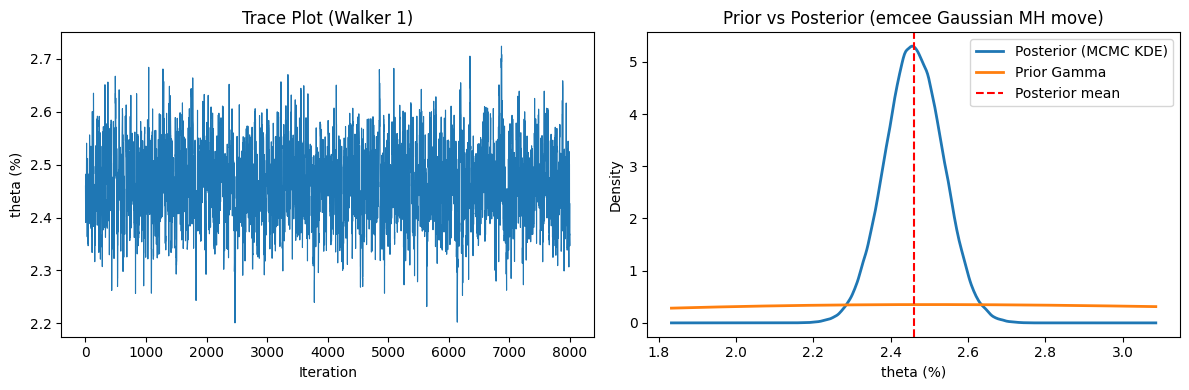

In [14]:
# Diagnostics + posterior visualization
chain_full = sampler.get_chain()[:, :, 0]  # shape: (n_steps, n_walkers)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Trace of one walker
axes[0].plot(chain_full[:, 0], linewidth=0.8)
axes[0].set_title('Trace Plot (Walker 1)')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('theta (%)')

# Prior vs posterior density
grid = np.linspace(max(0.01, draws.min() - 0.3), draws.max() + 0.3, 400)
post_kde = gaussian_kde(draws)
prior_pdf = gamma.pdf(grid, a=a_prior, scale=b_prior)

axes[1].plot(grid, post_kde(grid), label='Posterior (MCMC KDE)', linewidth=2)
axes[1].plot(grid, prior_pdf, label='Prior Gamma', linewidth=2)
axes[1].axvline(mcmc_mean, color='red', linestyle='--', label='Posterior mean')
axes[1].set_title('Prior vs Posterior (emcee Gaussian MH move)')
axes[1].set_xlabel('theta (%)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()


Posterior mean expected loss (MCMC): $738,135
90% posterior interval (MCMC): [$701,239, $774,937]


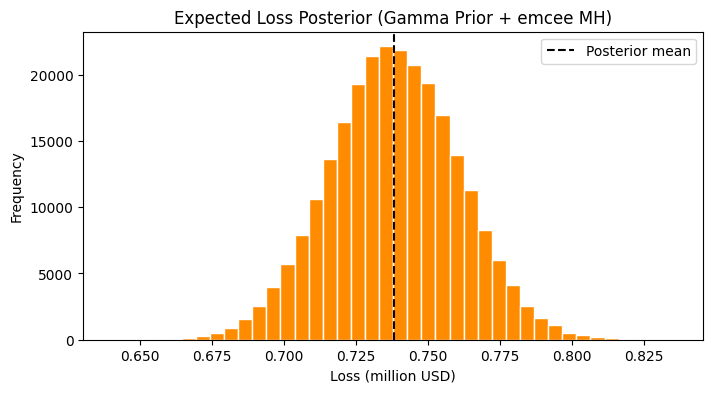

In [15]:
# Implied expected-loss distribution under emcee posterior draws
theta_draws = np.clip(draws, 0.0, None)
loss_draws_mcmc = ead * lgd * (theta_draws / 100.0)

loss_mean_mcmc = loss_draws_mcmc.mean()
loss_q05_mcmc, loss_q95_mcmc = np.quantile(loss_draws_mcmc, [0.05, 0.95])

print(f"Posterior mean expected loss (MCMC): ${loss_mean_mcmc:,.0f}")
print(f"90% posterior interval (MCMC): [${loss_q05_mcmc:,.0f}, ${loss_q95_mcmc:,.0f}]")

plt.figure(figsize=(8, 4))
plt.hist(loss_draws_mcmc / 1e6, bins=40, color='darkorange', edgecolor='white')
plt.axvline(loss_mean_mcmc / 1e6, color='black', linestyle='--', label='Posterior mean')
plt.title('Expected Loss Posterior (Gamma Prior + emcee MH)')
plt.xlabel('Loss (million USD)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


*Interpretation*: This version uses package-based MCMC (`emcee`) with a Gaussian Metropolis-Hastings move, so you can teach both non-conjugate Bayesian inference and practical sampler diagnostics with a production-grade library.

### Dropout in ML Training: Randomness as Regularization

In a neural network, dropout injects randomness during training:

$$
m_j \sim \text{Bernoulli}(q), \quad q = 1-p,
$$

where $p$ is dropout probability and $m_j$ is the random mask for hidden unit $j$.
With inverted dropout,

$$
h_j^{\text{train}} = \frac{m_j}{q} h_j,
$$

so

$$
\mathbb{E}[h_j^{\text{train}} \mid h_j] = h_j.
$$

This randomness perturbs each mini-batch update, discourages co-adaptation, and acts as stochastic regularization.


Dropout probability p = 0.35, keep probability q = 0.65
Empirical E[active units]: 41.72
Theoretical E[active units]: 41.60


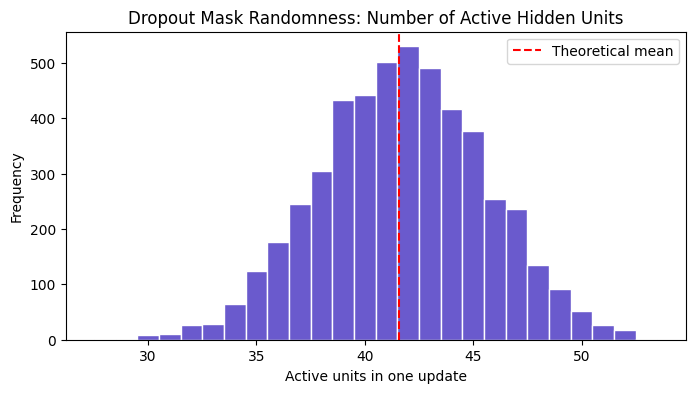

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Randomness of dropout masks (Bernoulli sampling)
rng = np.random.default_rng(5821)

n_units = 64
keep_prob = 0.65
drop_prob = 1 - keep_prob
n_trials = 5000

active_units = rng.binomial(n=n_units, p=keep_prob, size=n_trials)

print(f"Dropout probability p = {drop_prob:.2f}, keep probability q = {keep_prob:.2f}")
print(f"Empirical E[active units]: {active_units.mean():.2f}")
print(f"Theoretical E[active units]: {n_units * keep_prob:.2f}")

plt.figure(figsize=(8, 4))
plt.hist(active_units, bins=np.arange(active_units.min() - 0.5, active_units.max() + 1.5, 1),
         color='slateblue', edgecolor='white')
plt.axvline(n_units * keep_prob, color='red', linestyle='--', label='Theoretical mean')
plt.title('Dropout Mask Randomness: Number of Active Hidden Units')
plt.xlabel('Active units in one update')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Synthetic nonlinear classification data
X, y = make_moons(n_samples=1200, noise=0.30, random_state=5821)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5821)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)


class Net(nn.Module):
    def __init__(self, drop_p=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)


def fit_model(drop_p=0.0, seed=1, epochs=250, lr=0.02):
    torch.manual_seed(seed)
    model = Net(drop_p)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    hist = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for _ in range(epochs):
        model.train()
        opt.zero_grad()
        logits = model(X_train_t).squeeze(1)
        loss = loss_fn(logits, y_train_t)
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            tr_logits = model(X_train_t).squeeze(1)
            te_logits = model(X_test_t).squeeze(1)
            tr_prob = torch.sigmoid(tr_logits)
            te_prob = torch.sigmoid(te_logits)

            hist['train_loss'].append(loss_fn(tr_logits, y_train_t).item())
            hist['test_loss'].append(loss_fn(te_logits, y_test_t).item())
            hist['train_acc'].append(((tr_prob >= 0.5).float() == y_train_t).float().mean().item())
            hist['test_acc'].append(((te_prob >= 0.5).float() == y_test_t).float().mean().item())

    for k in hist:
        hist[k] = np.array(hist[k])

    summary = {k: float(v[-1]) for k, v in hist.items()}
    return model, hist, summary


No dropout:
  train acc = 0.935, test acc = 0.898
  train loss = 0.145, test loss = 0.237
With dropout (p=0.35):
  train acc = 0.940, test acc = 0.906
  train loss = 0.162, test loss = 0.222


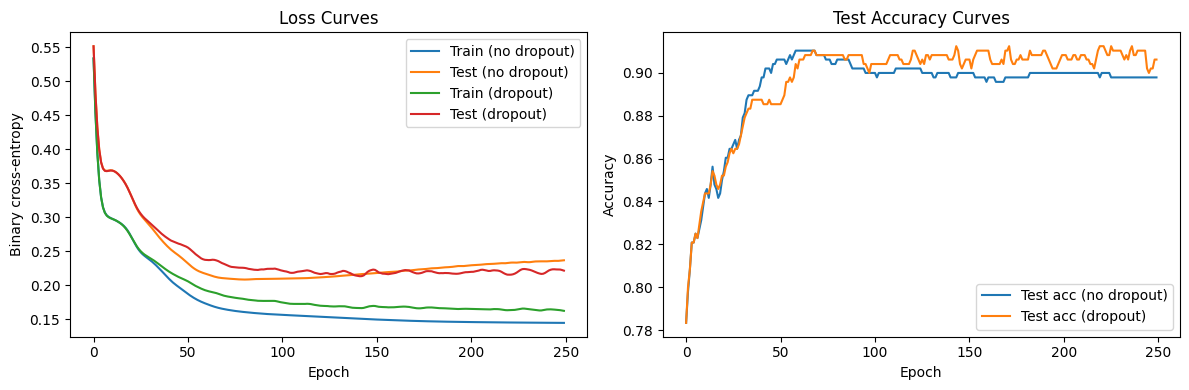

In [18]:
# Single-run comparison: no dropout vs dropout
_, hist_no, sum_no = fit_model(drop_p=0.0, seed=11)
_, hist_do, sum_do = fit_model(drop_p=0.35, seed=11)

print('No dropout:')
print(f"  train acc = {sum_no['train_acc']:.3f}, test acc = {sum_no['test_acc']:.3f}")
print(f"  train loss = {sum_no['train_loss']:.3f}, test loss = {sum_no['test_loss']:.3f}")

print('With dropout (p=0.35):')
print(f"  train acc = {sum_do['train_acc']:.3f}, test acc = {sum_do['test_acc']:.3f}")
print(f"  train loss = {sum_do['train_loss']:.3f}, test loss = {sum_do['test_loss']:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(hist_no['train_loss'], label='Train (no dropout)')
axes[0].plot(hist_no['test_loss'], label='Test (no dropout)')
axes[0].plot(hist_do['train_loss'], label='Train (dropout)')
axes[0].plot(hist_do['test_loss'], label='Test (dropout)')
axes[0].set_title('Loss Curves')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary cross-entropy')
axes[0].legend()

axes[1].plot(hist_no['test_acc'], label='Test acc (no dropout)')
axes[1].plot(hist_do['test_acc'], label='Test acc (dropout)')
axes[1].set_title('Test Accuracy Curves')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


Mean test acc (no dropout): 0.9021  | std: 0.0029
Mean test acc (dropout):    0.9090  | std: 0.0023


C:\Users\zhent\AppData\Local\Temp\ipykernel_31540\4123403480.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([acc_no, acc_do], labels=['No dropout', 'Dropout p=0.35'])


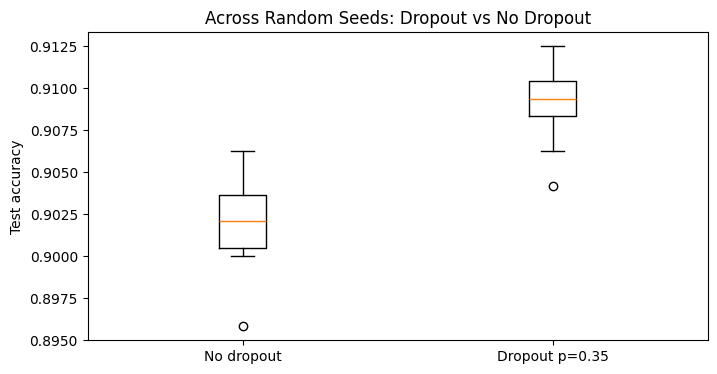

In [19]:
# Repeated runs: dropout as randomized regularization across seeds
n_rep = 10
acc_no = []
acc_do = []

for s in range(1, n_rep + 1):
    _, _, out_no = fit_model(drop_p=0.0, seed=s, epochs=180)
    _, _, out_do = fit_model(drop_p=0.35, seed=s, epochs=180)
    acc_no.append(out_no['test_acc'])
    acc_do.append(out_do['test_acc'])

acc_no = np.array(acc_no)
acc_do = np.array(acc_do)

print(f"Mean test acc (no dropout): {acc_no.mean():.4f}  | std: {acc_no.std():.4f}")
print(f"Mean test acc (dropout):    {acc_do.mean():.4f}  | std: {acc_do.std():.4f}")

plt.figure(figsize=(8, 4))
plt.boxplot([acc_no, acc_do], labels=['No dropout', 'Dropout p=0.35'])
plt.ylabel('Test accuracy')
plt.title('Across Random Seeds: Dropout vs No Dropout')
plt.show()


*Interpretation*: Dropout is explicit randomness in optimization. Each update uses a different random subnetwork, so the learner cannot rely on fragile feature co-adaptations. In this example, dropout usually lowers training fit but improves (or stabilizes) out-of-sample performance across random seeds.